##### Спецкурс "Методы и алгоритмы компьютерного зрения"

### Определение пола человека с помощью LBP и SVM
---

#### $\S$ 1. Постановка задачи

Дана выборка, представляющая собой изображения лиц мужчин и женщин. Хранится в файле "Face/Data.pkl" в виде словаря {'Face' : ListImage, 'Who' : Metki}, где ListImage -- изображение лиц, а Metki -- вектор, координаты которого -- это метки классов (1 - "мужчина", 0 -- "женщина"). Используя LBP-преобразование поставить в соответствие каждому изображению вектор-признак. Результаты сохранить в виде массива $X$, строки которой -- это найденные векторы. При нахождении вектора изображение делить на 25 прямоугольных областей (выбираем равномерную сетку $5\times5$). Построить решающую функцию на основе метода опорных векторов, разделяющую два класса -- мужчин и женщин.

#### $\S$ 2. Локальное двоичное разбиение

*Локальное двоичное разбиение (local binary partition, LBP)* представляет собой текстурную характеристику. На изображении выполним сравнение значения яркости каждого пикселя $\mathrm{p}$ и восьми его соседей. Результаты проверки 8 соседей можно представить в виде 8-разрядного двоичного числа $b_{1} b_{2}\dots b_{8} $, где $b_{i} = 0$, если яркость $i$-го соседа меньше яркости пикселя $\mathrm{p}$. В противном случае $b_{i} = 1$. Полученное двоичное число переводим в десятичную систему. Легко видеть, что в результате мы получим число, принадлежащее множеству $[0;255] \cap \mathbf{Z}$.

**Пример 1.** Вычисление $\mathrm{LBP}(f)(i,j)$

$$
\begin{vmatrix}77&76&77\\76&77&78\\77&77&79\end{vmatrix}~\rightarrow~\begin{vmatrix}1&0&1 \\ 0& &1\\ 1&1&1\end{vmatrix}
$$

$$
g(i,j)=\mathrm{LBP}(f)(i,j)=11111010=1\cdot 2^{7} +1\cdot 2^{6} +1\cdot 2^{5} +1\cdot 2^{4} +1\cdot 2^{3} +0\cdot 2^{2} +1\cdot 2^{1} +0\cdot 2^{0} =250.
$$

Для применения методов классификации необходимо описать изображения лиц мужчин и женщин с помощью некоторых признаков. Для этого изображение $\mathrm{LBP}(f)$ разбивается на прямоугольные области $R_{j},~j=1,2,\dots, m$ и для каждой области $R_{j} $, для каждого $i=0,1,\dots,255$ вычисляем количество $H_{i,j} $ пикселей в области $R_{j} $, у которых яркость равна $i$. Числа $H_{i,j},~i=0,1,\dots, 255,~j=1,2,\dots, m$ составляют координаты вектора, который ставится в соответствие данному изображению.

**Рекомендации.** Для уменьшения размерности пространства признаков изображение разбиваем на $5\times 5$ прямоугольных областей, а при вычислении $H_{i,j} $ находить их не для каждого $i=0,1,\dots, 255$, а разбить этот диапазон на $m$ частей $I_{1} ,\dots, I_{m} $ и вычислять $H_{i,j} $, как количество пикселей, у которых яркость принадлежит $I_{i}$. Положить $m=10$. Тогда размерность пространства признаков равна $5 \cdot 5\cdot 10=250$. Можно использовать np.histogram.

Координата вектор-признака изображения $f$:
$$
h_{i,j} = np.histogram(LBP(f)[(i \cdot h_x):((i + 1) \cdot h_x),(j \cdot h_y):((j + 1) \cdot h_y)].flatten(), m)[0]
$$
![Image](Face/LBP.png)

#### $\S$ 3. Пример построения решающей функции с помощью SVM в случае двумерного пространства признаков

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
''' Обучающая выборка. '''
m_1 = [0, 0]
m_2 = [2, 2]
sigma_1 = [2, 1]
sigma_2 = [2, 1]
N = 100
X_1 = np.concatenate([np.random.normal(m_1[0], sigma_1[0], N).reshape((-1, 1)),
                      np.random.normal(m_1[1], sigma_1[1], N).reshape((-1, 1))], axis = 1)
X_2 = np.concatenate([np.random.normal(m_2[0], sigma_2[0], N).reshape((-1, 1)),
                      np.random.normal(m_2[1], sigma_2[1], N).reshape((-1, 1))], axis = 1)
X = np.concatenate([X_1, X_2], axis = 0)
Y = np.zeros(X.shape[0])
Y[:N] = 0
Y[N:] = 1
print(X.shape)
print(Y.shape)

(200, 2)
(200,)


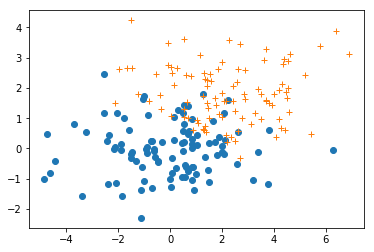

In [3]:
plt.figure()
plt.plot(X_1[:, 0], X_1[:, 1], 'o')
plt.plot(X_2[:, 0], X_2[:, 1], '+')

In [4]:
# Разбиваем данные на обучающую и тестирующую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
# Масштабируем обучающие данные так, что среднее 0 и дисперсия 1
X_train_scaled = sklearn.preprocessing.scale(X_train)
X_test_scaled = sklearn.preprocessing.scale(X_test)

In [5]:
svm = SVC(kernel = 'rbf')# {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# строим SVM на масштабированных обучающих данных
svm.fit(X_train_scaled, y_train)
# Оцениваем качество на масштабированных тестовых данных
print("Правильность на обучающем наборе: {:.2f}".format(svm.score(X_train_scaled, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 0.90
Правильность на тестовом наборе: 0.88


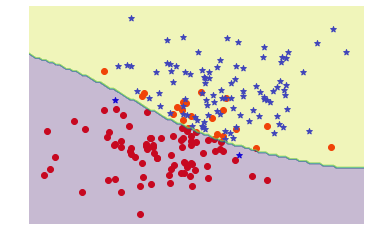

In [6]:
# Строим области предпочтения классов
N = 100
plt.figure()
ax = plt.gca()
ax.scatter(X_1[:, 0], X_1[:, 1], marker = 'o', c = [[1, 0, 0]])
ax.scatter(X_2[:, 0], X_2[:, 1], marker = '*', c = [[0, 0, 1]])
ax.axis('off')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num = 100), np.linspace(*ylim, num = 100))
A = sklearn.preprocessing.scale(np.concatenate([xx.reshape((-1, 1)),
                                                yy.reshape((-1, 1))], axis = 1))
d = svm.predict(A).reshape(xx.shape)
ax.contourf(xx, yy, d, alpha = 0.3)

#### $\S$ 4. Распознавание пола человека

In [7]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature # Здесь реализован LBP
%matplotlib inline

In [8]:
def load_obj():
    ''' Чтение из файла.'''
    obj = pickle.load(open('Face/Data.pkl', 'rb' ))
    return obj

In [9]:
''' 
Загружаем данные: изображения мужчин/женщин, метка: 1-мужчина, 0-женщина.
Прежде чем получить данные выборки необходимо загрузить файл с этими данными,
имеющий название 'Data.pkl', прилагаемый к этому блокноту
и хранящейся в папке 'PictFace'. Он должен отобразиться в разделе Files.
'''
Li = load_obj() # Словарь вида: {'Face' : ListImage, 'Who' : Metki}

In [10]:
Face = Li[('Face')]
Who = Li[('Who')]

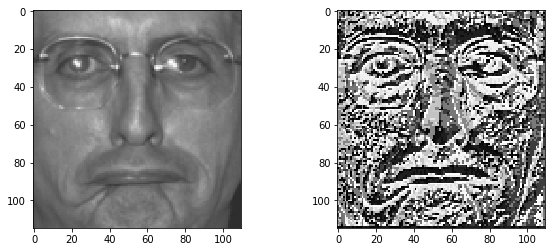

In [11]:
''' Проба. Лицо и его LBP преобразование.'''
im = Face[0]
#method = {‘default’, ‘ror’, ‘uniform’, ‘var’}
LBP_im = feature.local_binary_pattern(im, 8, 1, method='default')
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(Image.fromarray(LBP_im))
ax1.imshow(im)

In [13]:
def vector_lbp(g, n, m):
    '''
    Функция, вычисляющая по данному изображению g=LBP(f) вектор-признак x
    изображения. Изображение разбивается на nxn прямоугольных областей. Вход:
    LBP преобразованное изображение g, n x n - количество прямоугольных
    областей; m - количество промежутков, на которые делится область [0;256].
    '''
    
    # Ваш код
    
    return x

In [14]:
def Load_dataLBP(Face, Who, n, m):
    '''
    Формируем массив X размера N x s, содержащий вектор-признаки классов
    и массив Y, содержащий метки классов Y[i] = Who[i]
    s = размерности пространства признаков.
    '''
    
    # Ваш код
    
    return [X, Y]

In [15]:
''' Проба. '''
n = 5
m = 10
X, Y = Load_dataLBP(Face, Who, n, m)
print(X.shape)
print(Y.shape)

(600, 250)
(600,)


In [20]:
from sklearn.model_selection import train_test_split
import sklearn
# Разбиваем данные на обучающую и тестирующую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
# Масштабируем обучающие данные так, что среднее 0 и дисперсия 1
X_train_scaled = sklearn.preprocessing.scale(X_train)
X_test_scaled = sklearn.preprocessing.scale(X_test)

In [21]:
# SVM ...

Правильность на обучающем наборе: 1.00
Правильность на тестовом наборе: 0.95


## Литература

1. Hui-Cheng Lian and Bao-Liang Lu, Multi-view Gender Classification Using Local
Binary Patterns and Support Vector Machines. Springer-Verlag Berlin Heidelberg, pp. 202–209, 2006

2. Лепский А.Е., Броневич А.Г. Математические методы распознавания образов: Курс лекций. - Таганрог: Изд-во ТТИ ЮФУ, 2009. - 155 с